# Clustering

This notebook implements the clustering method described in [Snow Facies Over Ice Sheets Derived From Envisat Active and Passive Observations](https://www.researchgate.net/publication/220053326_Snow_Facies_Over_Ice_Sheets_Derived_From_Envisat_Active_and_Passive_Observations) and improves upon it.

In [1]:
import os
from os import path
import pandas
import numpy as np
from matplotlib import pyplot as plt
import random
import sys
import skfuzzy as fuzz
from sklearn.metrics import confusion_matrix


sys.path.append(os.path.abspath("../src/utils"))
import toolbox

In [2]:
df = toolbox.load_data()

Loading S3Acycle018.hdf
Loading S3Acycle047.hdf
Loading S3Acycle005.hdf
Loading S3Acycle039.hdf
Loading S3Acycle044.hdf
Loading S3Acycle041.hdf
Loading S3Acycle017.hdf
Loading S3Acycle032.hdf
Loading S3Acycle002.hdf
Loading S3Acycle049.hdf
Loading S3Acycle019.hdf
Loading S3Acycle008.hdf
Loading S3Acycle040.hdf
Loading S3Acycle035.hdf
Loading S3Acycle043.hdf
Loading S3Acycle012.hdf
Loading S3Acycle052.hdf
Loading S3Acycle011.hdf
Loading S3Acycle024.hdf
Loading S3Acycle027.hdf
Loading S3Acycle020.hdf
Loading S3Acycle038.hdf
Loading S3Acycle042.hdf
Loading S3Acycle021.hdf
Loading S3Acycle001.hdf
Loading S3Acycle046.hdf
Loading S3Acycle034.hdf
Loading S3Acycle029.hdf
Loading S3Acycle025.hdf
Loading S3Acycle036.hdf
Loading S3Acycle048.hdf
Loading S3Acycle031.hdf
Loading S3Acycle003.hdf
Loading S3Acycle016.hdf
Loading S3Acycle030.hdf
Loading S3Acycle006.hdf
Loading S3Acycle013.hdf
Loading S3Acycle010.hdf
Loading S3Acycle053.hdf
Loading S3Acycle028.hdf
Loading S3Acycle014.hdf
Loading S3Acycle

## Original Clustering

The original article gives the cluster centroids, but also the mean and standard deviation used. The classificaiton can be done according to them. 

In [3]:
# Centroids for the 6 original groups
# x1: sig0_ku, x2: tb_avg, x3: tb_ratio, x4: sig0 diff ku/S 
envisat_cntr = np.array([
    [-1.7687, 1.6004, 1.0223, -1.6125],
    [-0.0572, -0.9718, -1.1724, 0.0599],
    [-1.0752, 0.1278, 0.2710, -0.8156],
    [0.3435, 0.5521, 0.4000, 0.1178],
    [0.8021, -0.3529, 0.3066, 0.6574],
    [0.2705, -0.0926, -0.3545, 0.1738]
])

envisat_means = np.array([
    [8.5433, 190.0169, -0.0147, -0.6846]
])

envisat_stds = np.array([
    [3.8460, 23.0642, 0.0153, 2.3071]
])

Since the original article uses the S band of Envisat but Sentinel-3 has a C-band instead, 2 clustering are done. One by ignoring the *sig0* different, one using the Ku/C difference instead.

In [4]:
# Fuzzy C-means parameters
m = 2
err = 0.005
maxiter = 1000
ncenters = 6

# Preparing numpy data
data = np.vstack((df["sig0_ice_sheet_01_ku"], df["tb_avg"], df["tb_ratio"], df["ku_c_diff"]))

# Normalising
data = ((data.T - envisat_means) / envisat_stds).T

# With all 4 variables
u, u0, d, jm, p, fpc = fuzz.cluster.cmeans_predict(data, envisat_cntr, m, error=err, maxiter=maxiter, init=None, seed=42)
cluster_membership_4vars = np.argmax(u, axis=0)

# With 3 variables
u, u0, d, jm, p, fpc = fuzz.cluster.cmeans_predict(data[:3, :], envisat_cntr[:, :3], m, error=err, maxiter=maxiter, init=None, seed=42)
cluster_membership_3vars = np.argmax(u, axis=0)

Let's compare those classification to the provided classification.

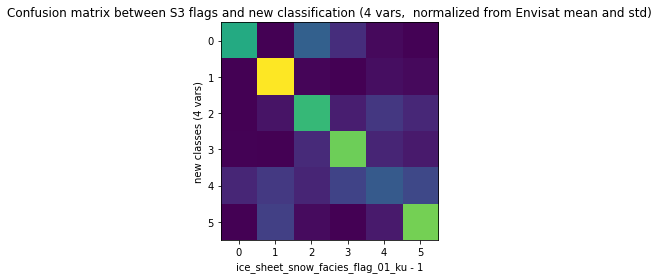

In [5]:
mat = confusion_matrix(cluster_membership_4vars, df["ice_sheet_snow_facies_flag_01_ku"] - 1, normalize="true")
plt.title("Confusion matrix between S3 flags and new classification (4 vars,  normalized from Envisat mean and std)")
plt.xlabel('ice_sheet_snow_facies_flag_01_ku - 1')
plt.ylabel('new classes (4 vars)')
plt.imshow(mat)
plt.show()

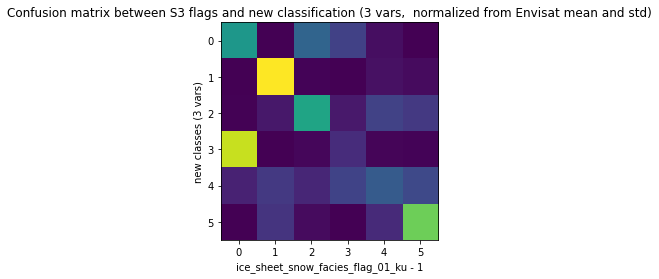

In [6]:
mat = confusion_matrix(cluster_membership_3vars, df["ice_sheet_snow_facies_flag_01_ku"] - 1, normalize="true")
plt.title("Confusion matrix between S3 flags and new classification (3 vars,  normalized from Envisat mean and std)")
plt.xlabel('ice_sheet_snow_facies_flag_01_ku - 1')
plt.ylabel('new classes (3 vars)')
plt.imshow(mat)
plt.show()

The classification does not seem to work properly. This can be due to a difference in equipement and hence in the mean value and deviation of the measurements.

This problem can be fixed by using computed mean and standard deviations instead of the one provided for Envisat. 

In [7]:
# Preparing numpy data
data = np.vstack((df["sig0_ice_sheet_01_ku"], df["tb_avg"], df["tb_ratio"], df["ku_c_diff"]))

# Normalising
means = data.mean(axis=1)
stds = data.std(axis=1)
data = ((data.T - means) / stds).T

# With all 4 variables
u, u0, d, jm, p, fpc = fuzz.cluster.cmeans_predict(data, envisat_cntr, m, error=err, maxiter=maxiter, init=None, seed=42)
cluster_membership_4vars = np.argmax(u, axis=0)

# With 3 variables
u, u0, d, jm, p, fpc = fuzz.cluster.cmeans_predict(data[:3, :], envisat_cntr[:, :3], m, error=err, maxiter=maxiter, init=None, seed=42)
cluster_membership_3vars = np.argmax(u, axis=0)

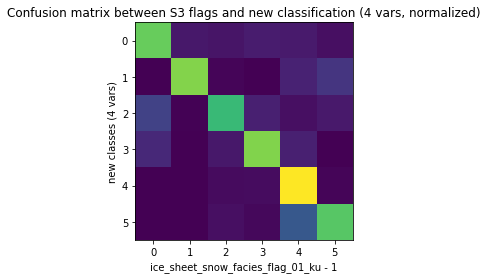

In [8]:
mat = confusion_matrix(cluster_membership_4vars, df["ice_sheet_snow_facies_flag_01_ku"] - 1, normalize="true")
plt.title("Confusion matrix between S3 flags and new classification (4 vars, normalized)")
plt.xlabel('ice_sheet_snow_facies_flag_01_ku - 1')
plt.ylabel('new classes (4 vars)')
plt.imshow(mat)
plt.show()

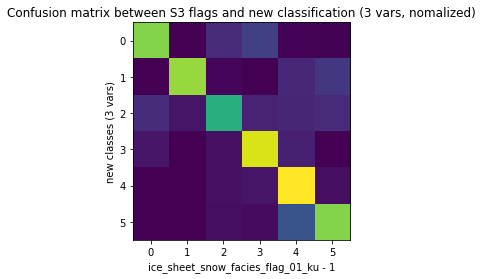

In [9]:
mat = confusion_matrix(cluster_membership_3vars, df["ice_sheet_snow_facies_flag_01_ku"] - 1, normalize="true")
plt.title("Confusion matrix between S3 flags and new classification (3 vars, nomalized)")
plt.xlabel('ice_sheet_snow_facies_flag_01_ku - 1')
plt.ylabel('new classes (3 vars)')
plt.imshow(mat)
plt.show()

Now the classification is very similar to the flag provided by ESA. The small difference can be explained by the difference in normalisation in they used a differente timeframe for the mean and std. Unfortunatelly, the technical documentation does not seem to provide the mean and standard deviation used to compute the flag (nor does it confirms that the centroids used are indeed the one provided in the paper).

## Reimplementation

Since the classification is using different instruments than the ones on Envisat, it might be useful to recompute the centroids for the Sentinel data.

We'll be using the year 2017 as training data.

In [10]:
from importlib import reload
toolbox = reload(toolbox)

In [11]:
df2017 = df[
    (df["time_01"] >= toolbox.str_to_ESA_time("2017-01-01 00:00:00"))
    & (df["time_01"] < toolbox.str_to_ESA_time("2018-01-01 00:00:00"))
]

In [12]:
df2017.count()

time_01              353620
lat_01               353620
lon_01               353620
tb_238_01            353620
tb_365_01            353620
                      ...  
waveform_20_c_127    353620
cycle                353620
tb_ratio             353620
tb_avg               353620
ku_c_diff            353620
Length: 286, dtype: int64

In [13]:
# Preparing numpy data
data = np.vstack((df2017["sig0_ice_sheet_01_ku"], df2017["tb_avg"], df2017["tb_ratio"], df2017["ku_c_diff"]))

# Normalising
means2017 = data.mean(axis=1)
stds2017 = data.std(axis=1)
data = ((data.T - means2017) / stds2017).T

cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(data, ncenters, m, error=err, maxiter=maxiter, init=None, seed=42)
cluster_membership_reimpl = np.argmax(u, axis=0)

In [14]:
cntr

array([[-0.05350247, -0.11115068, -0.42735937, -0.10988114],
       [ 0.16670508,  0.4364032 ,  0.36968444, -0.15447393],
       [-1.84092689,  0.88508785,  1.0794314 , -1.36740316],
       [-0.87764688,  1.21594707,  1.06945959,  0.30052203],
       [ 0.53347028, -0.82427216, -1.05419321,  0.31457052],
       [ 0.62550542, -0.4640894 ,  0.08054703,  0.28332542]])

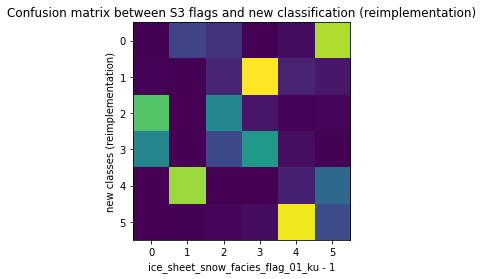

In [15]:
mat = confusion_matrix(cluster_membership_reimpl, df2017["ice_sheet_snow_facies_flag_01_ku"] - 1, normalize="true")
plt.title("Confusion matrix between S3 flags and new classification (reimplementation)")
plt.xlabel('ice_sheet_snow_facies_flag_01_ku - 1')
plt.ylabel('new classes (reimplementation)')
plt.imshow(mat)
plt.show()

In [16]:
df2017.groupby("cycle")["time_01"].count()

cycle
12     2806
13    26045
14    26047
15    26123
16    26006
17    26009
18    26004
19    26356
20    26461
21    26126
22    26286
23    26218
24    26254
25    26149
26    10730
Name: time_01, dtype: int64

In [17]:
def drawCycle(dataframe, cycle, cluster_membership_reimpl):
    plt.figure(figsize=(10, 10))
    plt.suptitle("Map of classes on cycle %d. (from %s to %s)" % (
        cycle,
        toolbox.ESA_time_to_datetime(dataframe[dataframe["cycle"] == cycle]["time_01"].min()).strftime("%b %Y"),
        toolbox.ESA_time_to_datetime(dataframe[dataframe["cycle"] == cycle]["time_01"].max()).strftime("%b %Y")
    ))
    plt.subplot(1, 2, 1)
    plt.title("Reimplementation")
    toolbox.drawGreenland(dataframe[dataframe["cycle"] == cycle], "lon_01", "lat_01", cluster_membership_reimpl[dataframe["cycle"] == cycle])
    plt.subplot(1, 2, 2)
    plt.title("Old")
    toolbox.drawGreenland(dataframe[dataframe["cycle"] == cycle], "lon_01", "lat_01", "ice_sheet_snow_facies_flag_01_ku")
    plt.show()

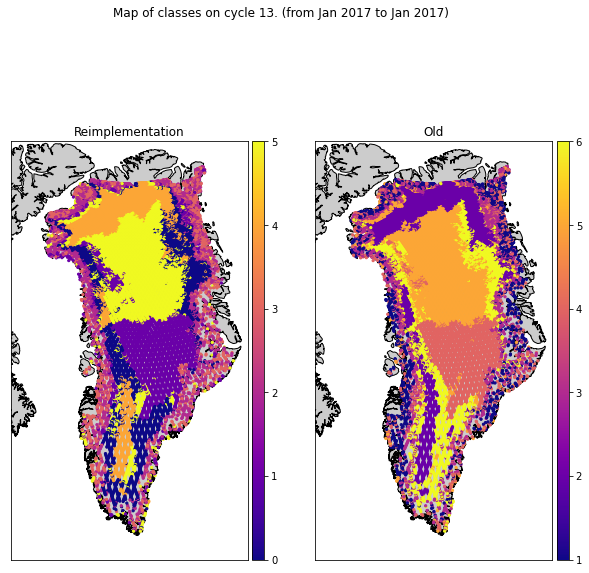

In [18]:
drawCycle(df2017, 13, cluster_membership_reimpl)

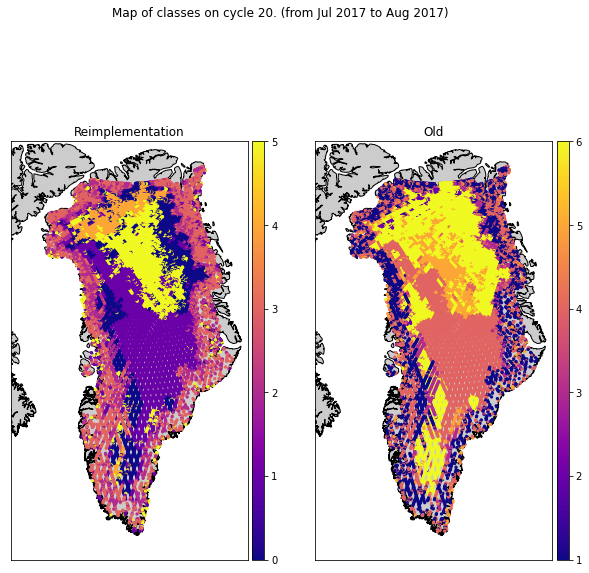

In [19]:
drawCycle(df2017, 20, cluster_membership_reimpl)

## Improvements

### Include waveform data

The original classification does not contain waveform caracteristics. To improve upon the classification, waveform parameters are added to the fuzzy clustering.

Namely, *sig0* and *width* of the leading edge, slopes of the trailing edge and peakiness of the wave.


In [20]:
# Preparing the data, filtering NaN
df2017_filtered = df2017[[
    "time_01",
    "lon_01",
    "lat_01",
    "cycle",
    "sig0_ice_sheet_01_ku",
    "tb_avg",
    "tb_ratio",
    "ku_c_diff",
    "sig0_leading_edge_ice_20_plrm_ku",
    "width_leading_edge_ice_20_plrm_ku",
    "slope_first_trailing_edge_ice_20_plrm_ku",
    "slope_second_trailing_edge_ice_20_plrm_ku",
    "peakiness_1_20_plrm_ku",
    "ice_sheet_snow_facies_flag_01_ku"
]].dropna()
df2017_filtered.count()

time_01                                      289383
lon_01                                       289383
lat_01                                       289383
cycle                                        289383
sig0_ice_sheet_01_ku                         289383
tb_avg                                       289383
tb_ratio                                     289383
ku_c_diff                                    289383
sig0_leading_edge_ice_20_plrm_ku             289383
width_leading_edge_ice_20_plrm_ku            289383
slope_first_trailing_edge_ice_20_plrm_ku     289383
slope_second_trailing_edge_ice_20_plrm_ku    289383
peakiness_1_20_plrm_ku                       289383
ice_sheet_snow_facies_flag_01_ku             289383
dtype: int64

In [21]:
# Preparing numpy data
data = np.array(df2017_filtered[[
    "sig0_ice_sheet_01_ku",
    "tb_avg",
    "tb_ratio",
    "ku_c_diff",
    "sig0_leading_edge_ice_20_plrm_ku",
    "width_leading_edge_ice_20_plrm_ku",
    "slope_first_trailing_edge_ice_20_plrm_ku",
    "slope_second_trailing_edge_ice_20_plrm_ku",
    "peakiness_1_20_plrm_ku"
]]).T

# Normalising
means2017 = data.mean(axis=1)
stds2017 = data.std(axis=1)
data = ((data.T - means2017) / stds2017).T

# Clustering
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(data, ncenters, m, error=err, maxiter=maxiter, init=None, seed=42)
cluster_membership_improved = np.argmax(u, axis=0)

In [22]:
means2017

array([ 4.69250804e+01,  1.91381168e+02, -1.70838592e-02,  3.42214406e+01,
        1.27230489e+01,  2.30268534e+00, -2.60835567e+06, -3.54790703e+06,
        3.13910347e+00])

In [23]:
stds2017

array([4.88550866e+00, 1.98794664e+01, 1.92515558e-02, 2.71847707e+00,
       5.09439237e+00, 1.91468415e+00, 9.02584905e+06, 2.21706204e+07,
       3.74800896e+00])

In [24]:
cntr

array([[ 0.48700299, -0.57619505, -0.63408324,  0.37356431,  0.41946903,
        -0.37132461, -0.06642231, -0.00478336, -0.06148108],
       [-0.34690022,  0.29683807,  0.17082815, -0.24323184, -0.31821679,
         0.27194131,  0.07339094,  0.01071907, -0.00388962],
       [ 0.08840454,  0.1431985 ,  0.1297503 , -0.02956412,  0.10700542,
        -0.04560774, -0.03289284, -0.00423564, -0.02991341],
       [-0.33261953,  0.30013345,  0.17603445, -0.23836   , -0.30248955,
         0.26263236,  0.06828402,  0.010019  , -0.00480154],
       [ 0.55376176, -0.27857237,  0.04893178,  0.2753551 ,  0.52866429,
        -0.37602891, -0.10626009, -0.01647906, -0.05996462],
       [-0.97050759,  0.4824235 ,  0.39112117, -0.57233359, -0.9387781 ,
         0.5206001 ,  0.22373968,  0.03482209,  0.02357736]])

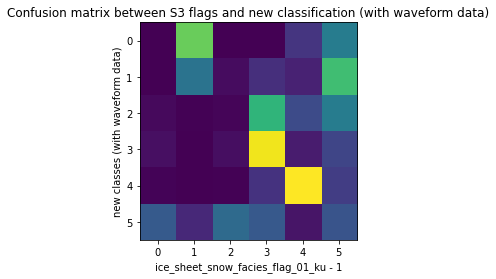

In [25]:
# Confusion matrix
mat = confusion_matrix(cluster_membership_improved, df2017_filtered["ice_sheet_snow_facies_flag_01_ku"] - 1, normalize="true")
plt.title("Confusion matrix between S3 flags and new classification (with waveform data)")
plt.xlabel('ice_sheet_snow_facies_flag_01_ku - 1')
plt.ylabel('new classes (with waveform data)')
plt.imshow(mat)
plt.show()

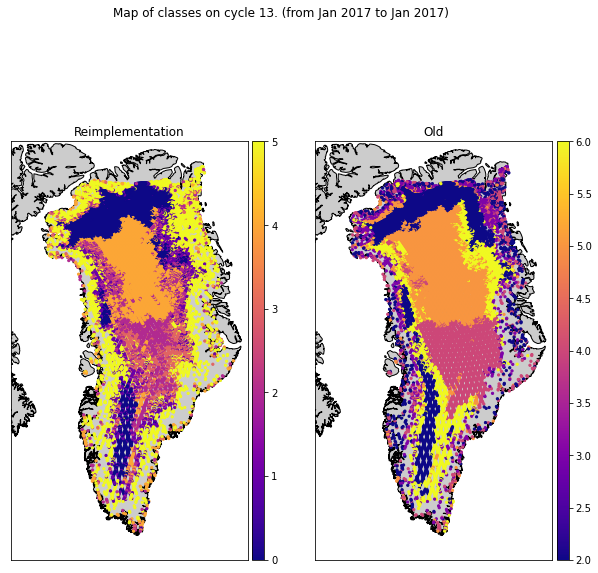

In [26]:
drawCycle(df2017_filtered, 13, cluster_membership_improved)

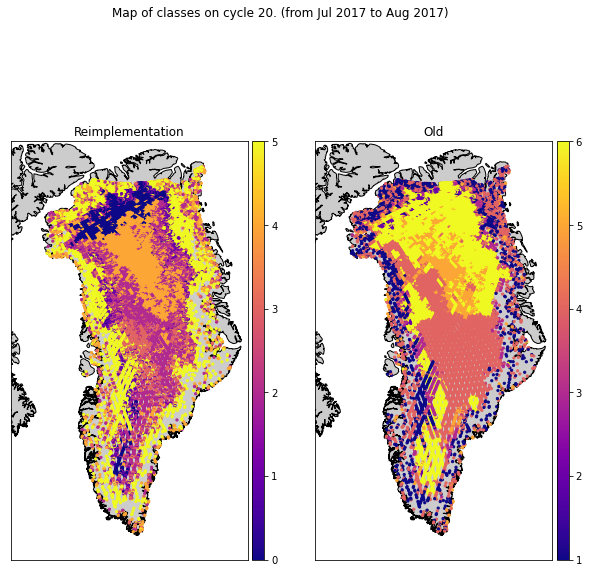

In [27]:
drawCycle(df2017_filtered, 20, cluster_membership_improved)